# Проект "Дашборд конверсий"

In [210]:
import os
import pandas as pd
import numpy as np
import requests
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
pd.options.mode.chained_assignment = None  # default='warn'

## Получаем данные по регистрациям и посещениям по API, по рекламным кампаниям из CSV на drive.google.com

In [211]:
#Данные по посещениям
req_visits = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
df_visits = pd.DataFrame(req_visits.json())

#Данные по регистрациям
req_registrations = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')
df_registrations = pd.DataFrame(req_registrations.json())

#Данные по по рекламным кампаниям
df_ads = pd.read_csv('https://drive.google.com/uc?id=12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj')

## Агрегируем данные по регистрациям и посещениям и сохраняем полученный датафрейм в conversion.json

In [212]:
#Агрегируем данные по посещениям

##Группируем по visit_id, берем только последнее посещение
df_visits['datetime'] = pd.to_datetime(df_visits['datetime'])
df_visits_last = df_visits.loc[df_visits.groupby('visit_id')['datetime'].idxmax()]

##Отфильтровываем посещения ботов
df_visits_filtered = df_visits_last[~df_visits_last['user_agent'].str.contains('bot', case=False)]

##Группируем посещения по дате и платформе
df_visits_filtered['datetime'] = df_visits_filtered['datetime'].dt.strftime('%Y-%m-%d')
df_visits_grouped = df_visits_filtered.groupby(['datetime', 'platform']).size().reset_index(name='visits')

##Переименовываем столбцы согласно заданию
df_visits_grouped.columns = ['date_group', 'platform', 'visits']

#Агрегируем данные по регистрациям
##Группируем регистрации по дате и платформе
df_registrations['date_group'] = pd.to_datetime(df_registrations['datetime']).dt.strftime('%Y-%m-%d')
df_registrations_grouped = df_registrations.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

#Объединяем датасэты
df_conversions = pd.merge(df_visits_grouped, df_registrations_grouped, on=['date_group', 'platform'], how='outer')

#Считаем конверсию из посещений в регистрацию
df_conversions['conversion'] = (df_conversions['registrations'] * 100 / df_conversions['visits']).round(2)

#Сортируем строки согласно заданию
df_conversions = df_conversions.sort_values(by='date_group')

#Сохраняем полученный датафрейм в формате JSON
df_conversions.to_json('conversion.json')

## Агрегируем данные по рекламным кампаниям и сохраняем полученный датафрейм в ads.json

In [213]:
#Группируем рекламу по дате и компании, считаем стоимость
df_ads['date_group'] = pd.to_datetime(df_ads['date']).dt.strftime('%Y-%m-%d')
df_ads_grouped = df_ads.groupby(['date_group']).agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()

#Объединяем полученный датафрейм с df_conversions
df_result = pd.merge(df_conversions, df_ads_grouped, on='date_group', how='left')

#Заполняем пустые значения в датафрейме
df_result['cost'] = df_result['cost'].fillna(0)
df_result['utm_campaign'] = df_result['utm_campaign'].fillna('none')

#Сортируем строки согласно заданию
df_result = df_result.sort_values(by='date_group')

#Сохраняем полученный датафрейм в формате JSON
df_result.to_json('ads.json')

# Создаем директорию для выгрузки графиков в формате PNG

In [214]:
#Создадим директорию
try:
    os.makedirs('./charts')
except FileExistsError:
    print('Невозможно создать директорию, так как она уже существует')

# График "Итоговые визиты"

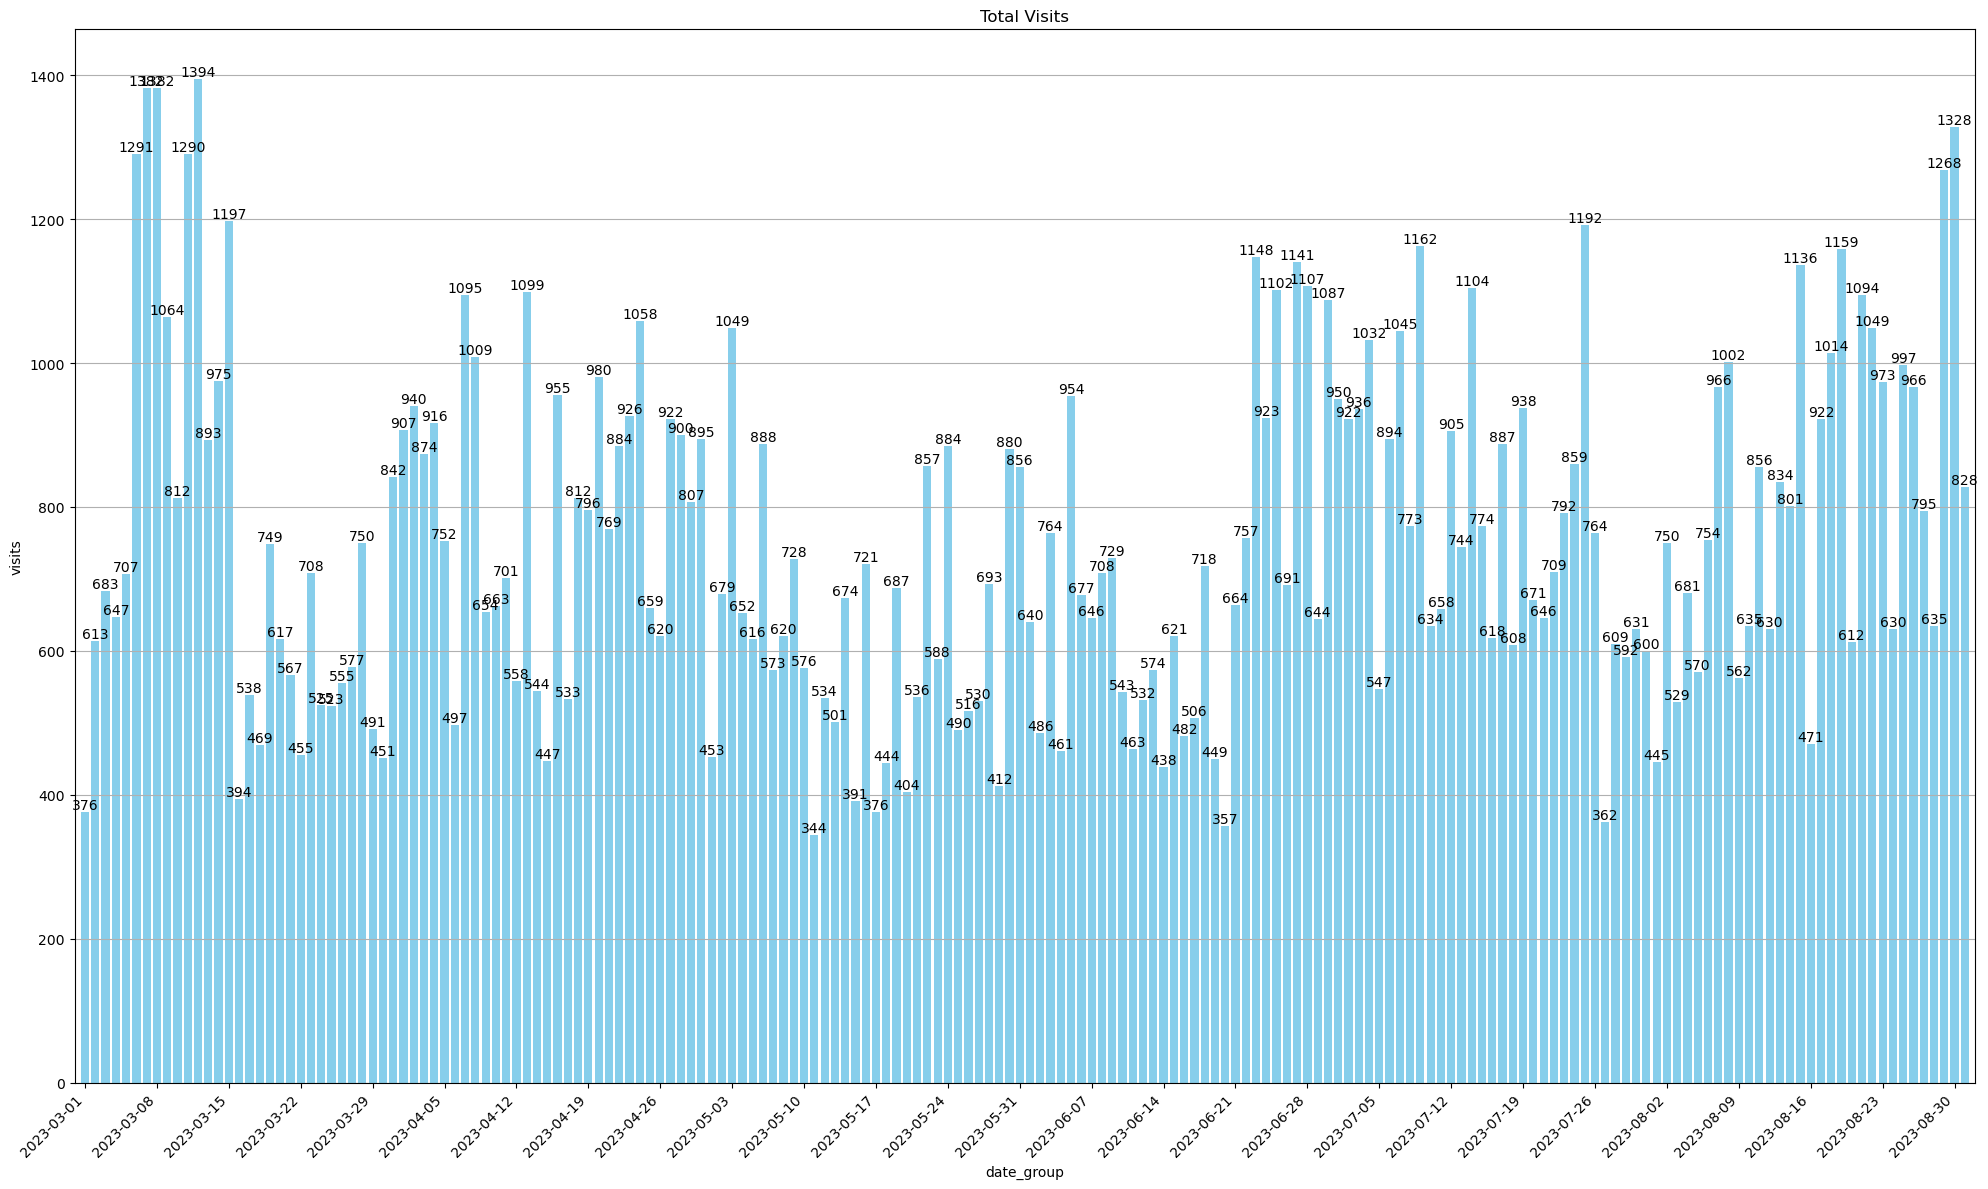

In [215]:
#Агрегируем данные
data = df_result.groupby('date_group')['visits'].sum().reset_index()

#Создаем график
plt.figure(figsize=(20, 12))
bars = plt.bar(data['date_group'], data['visits'], color='skyblue')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Total Visits')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.xlim(-1, len(data['date_group']))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/total_visits.png')

#Отрисовываем график
plt.show()

# График "Итоговые визиты с разбивкой по платформам: web, android, ios"

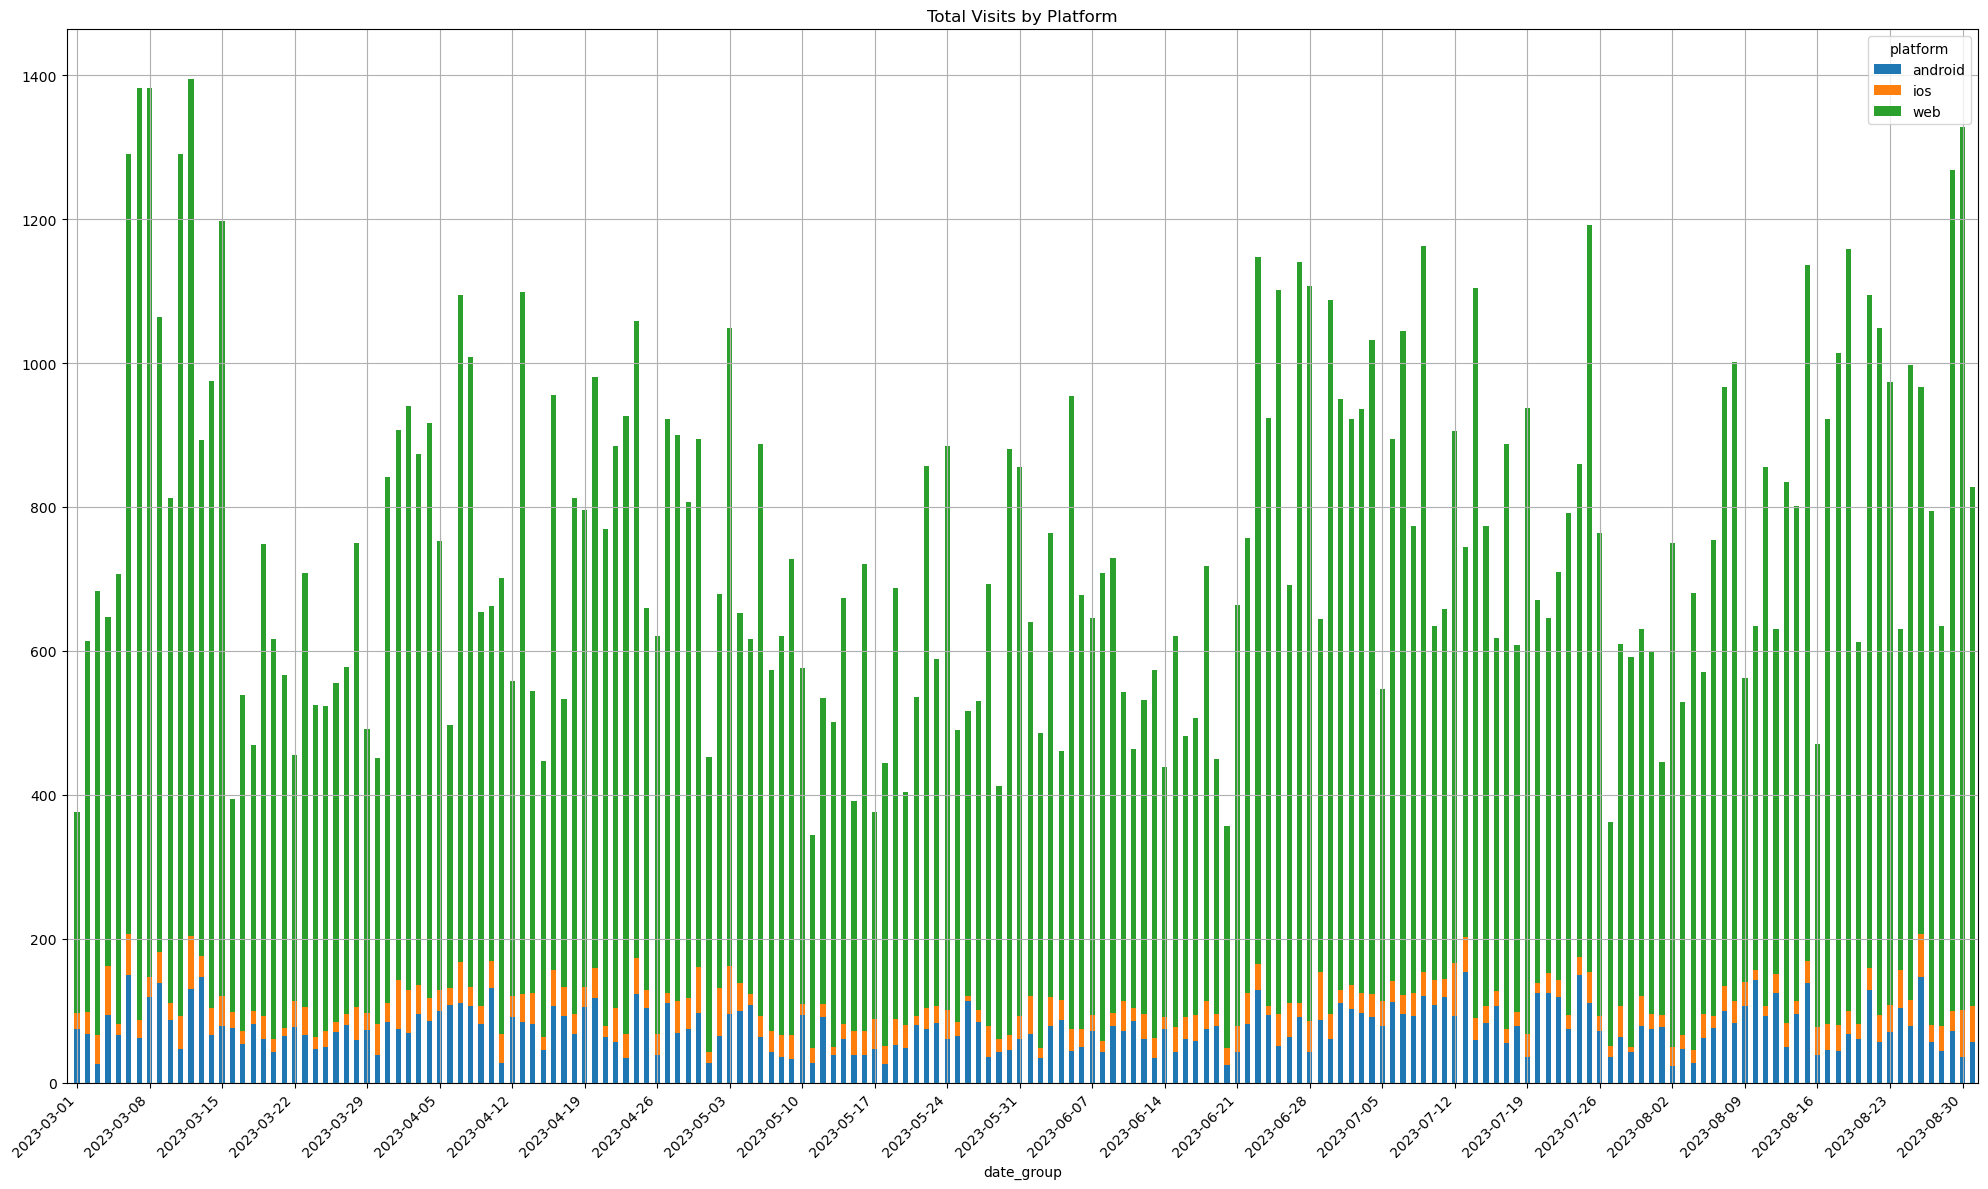

In [216]:
#Агрегируем данные
data = df_result.pivot_table(values='visits', index='date_group', columns='platform', aggfunc='sum')

#Создаем график
fig, ax = plt.subplots(figsize=(20, 12))
data.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('date_group')
ax.set_title('Total Visits by Platform')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xlim(-1,)
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/total_visits_by_platform.png')

#Отрисовываем график
plt.show()

# График "Итоговые регистрации"

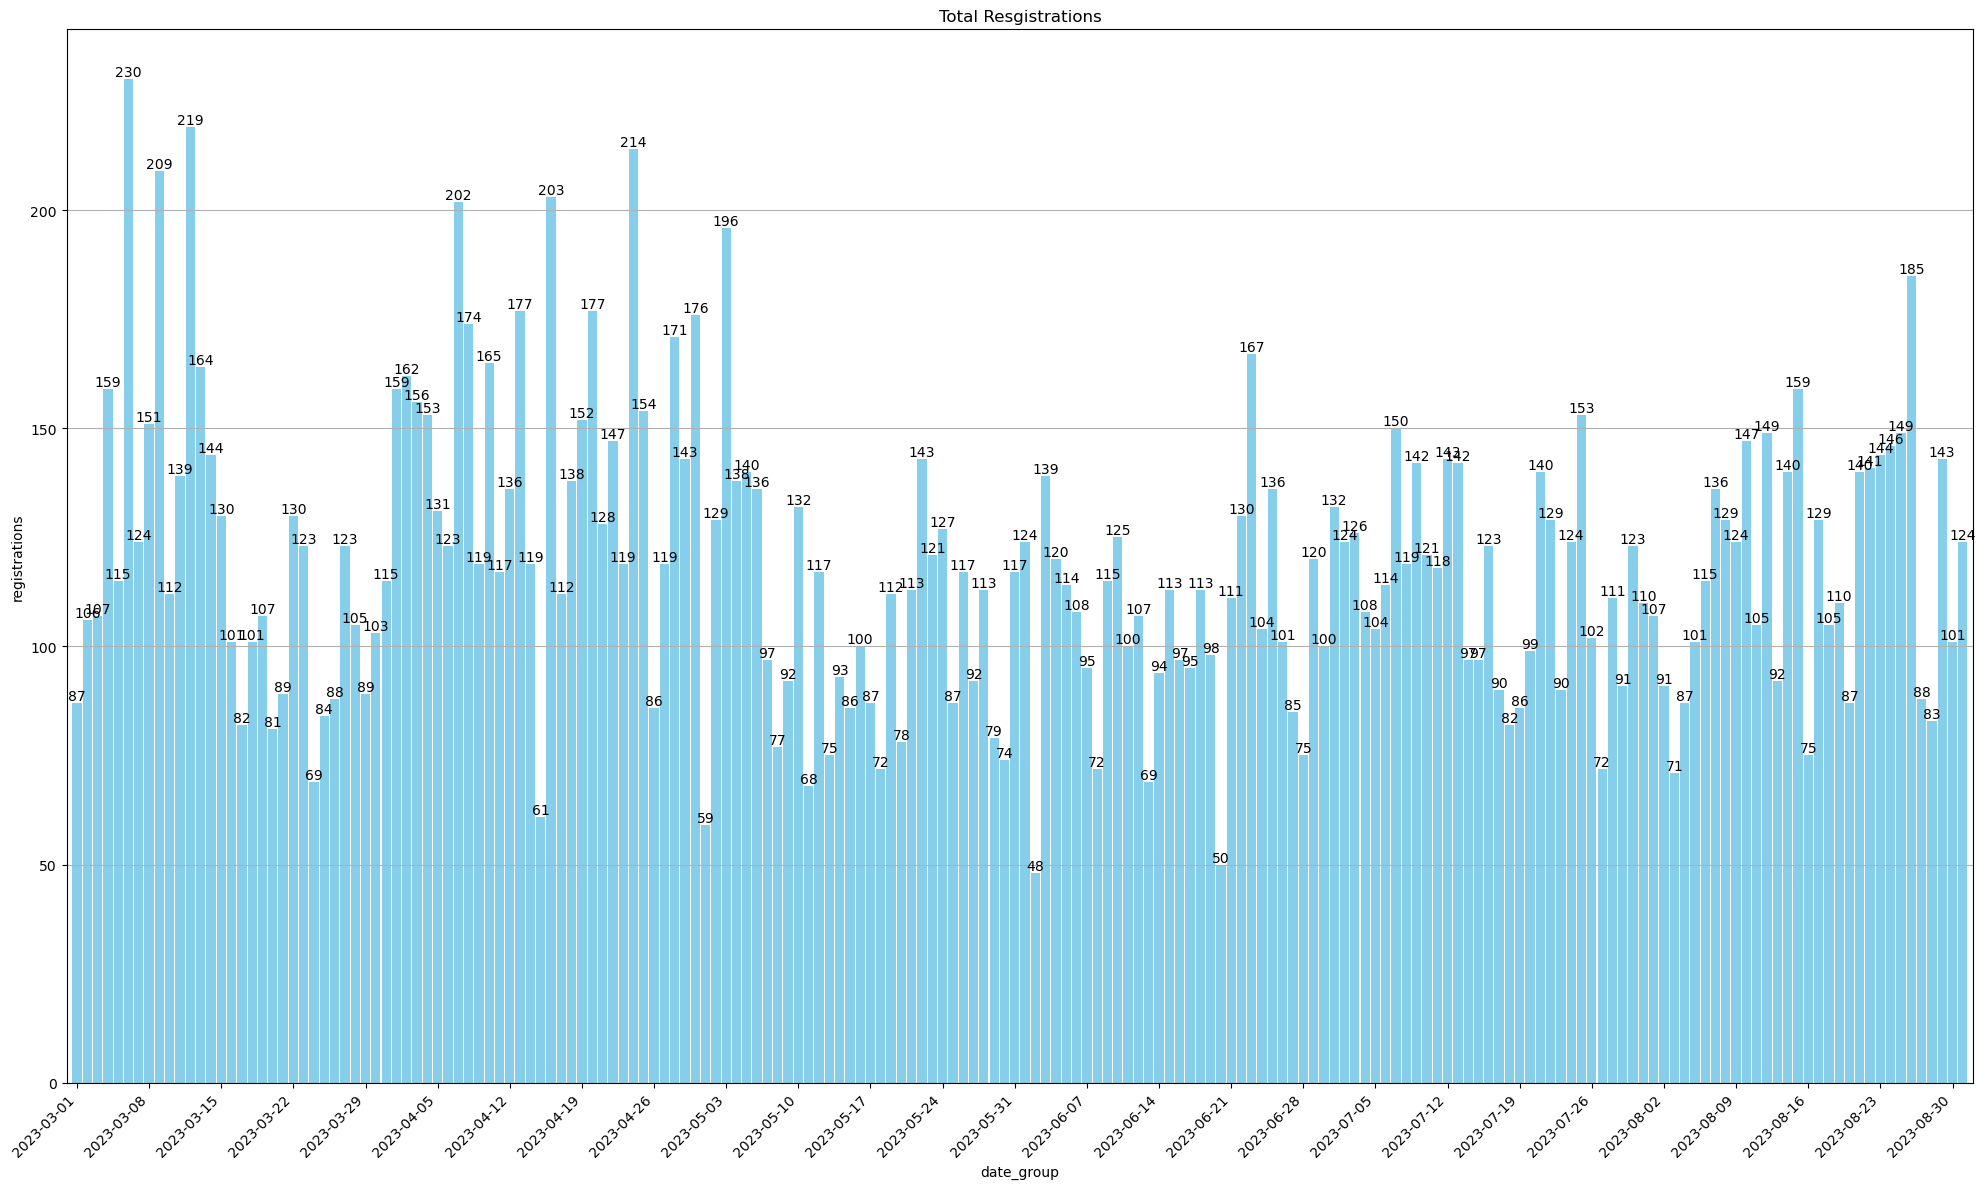

In [217]:
#Агрегируем данные
data = df_result.groupby('date_group')['registrations'].sum().reset_index()

#Создаем график
plt.figure(figsize=(20, 12))
bars = plt.bar(data['date_group'], data['registrations'], color='skyblue', width=0.9)
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Total Resgistrations')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xlim(-1, len(data['date_group']))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', color='black')
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/total_resgistrations.png')

#Отрисовываем график
plt.show()

# График "Итоговые регистрации с разбивкой по платформе: web, android, ios"

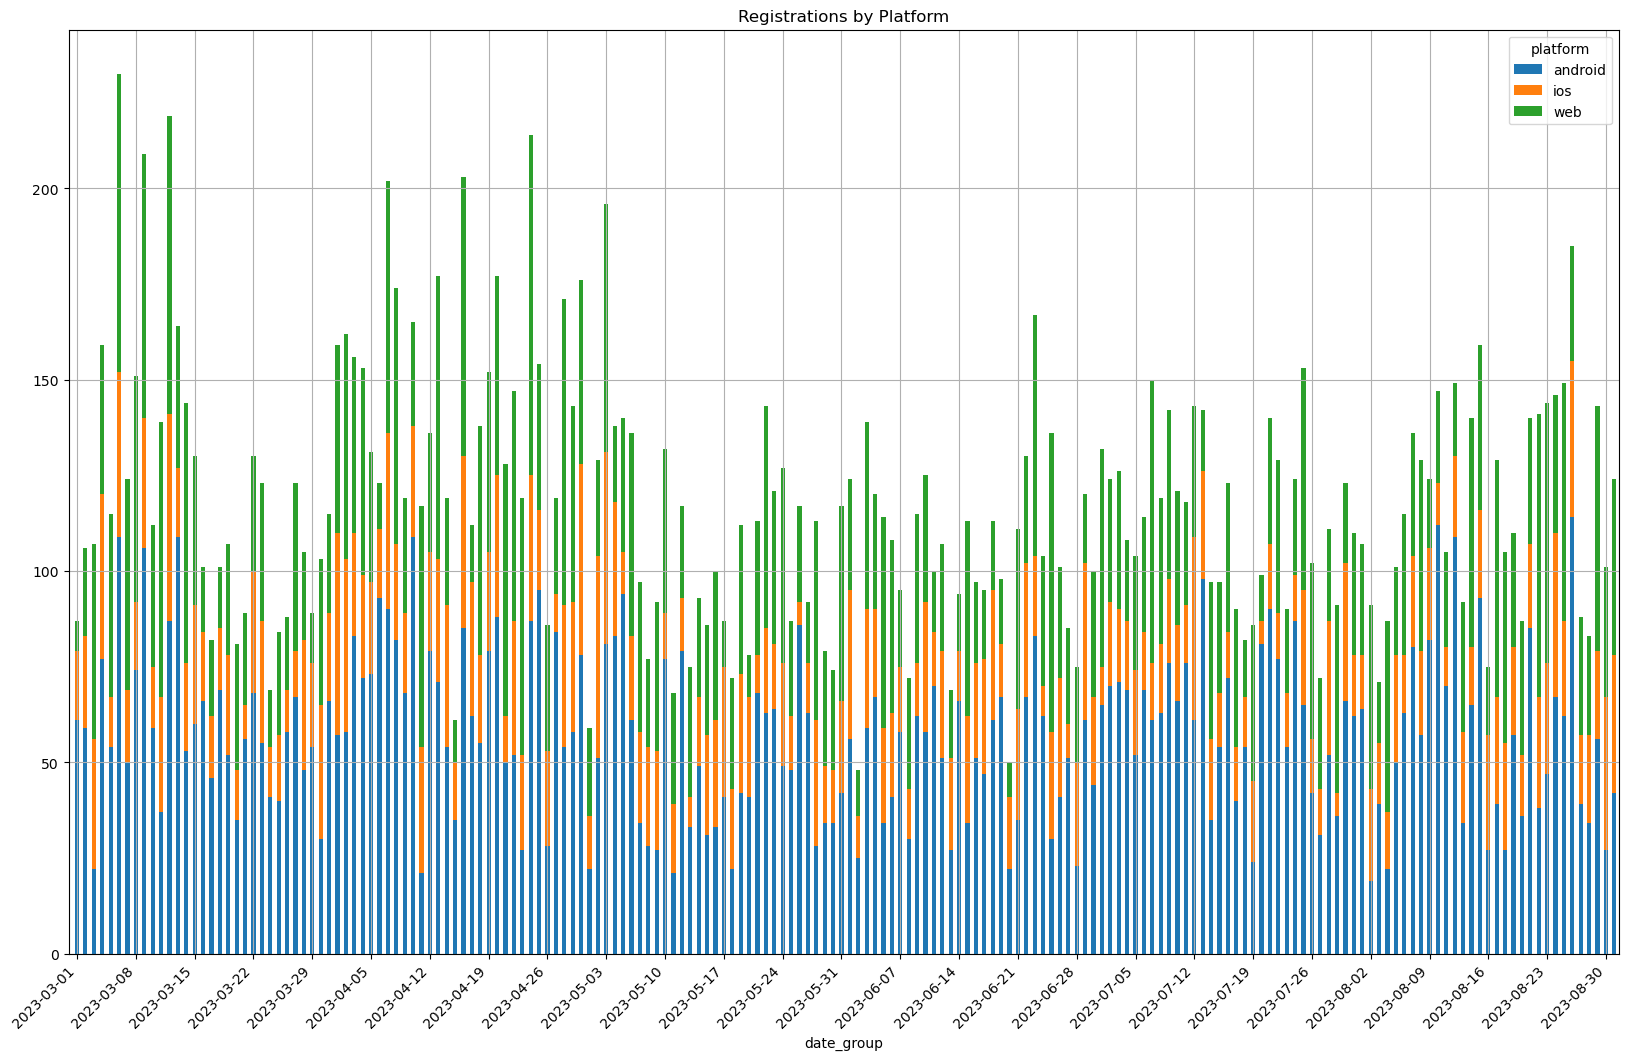

In [218]:
#Агрегируем данные
data = df_result.pivot_table(values='registrations', index='date_group', columns='platform', aggfunc='sum')

#Создаем график
fig, ax = plt.subplots(figsize=(20, 12))
data.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('date_group')
ax.set_title('Registrations by Platform')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xlim(-1,)
plt.xticks(rotation=45, ha='right')
ax.grid()

#Сохраняем график в формате PNG
plt.savefig('./charts/registrations_by_platform.png')

#Отрисовываем график
plt.show()

# График "Конверсия по каждой платформе"

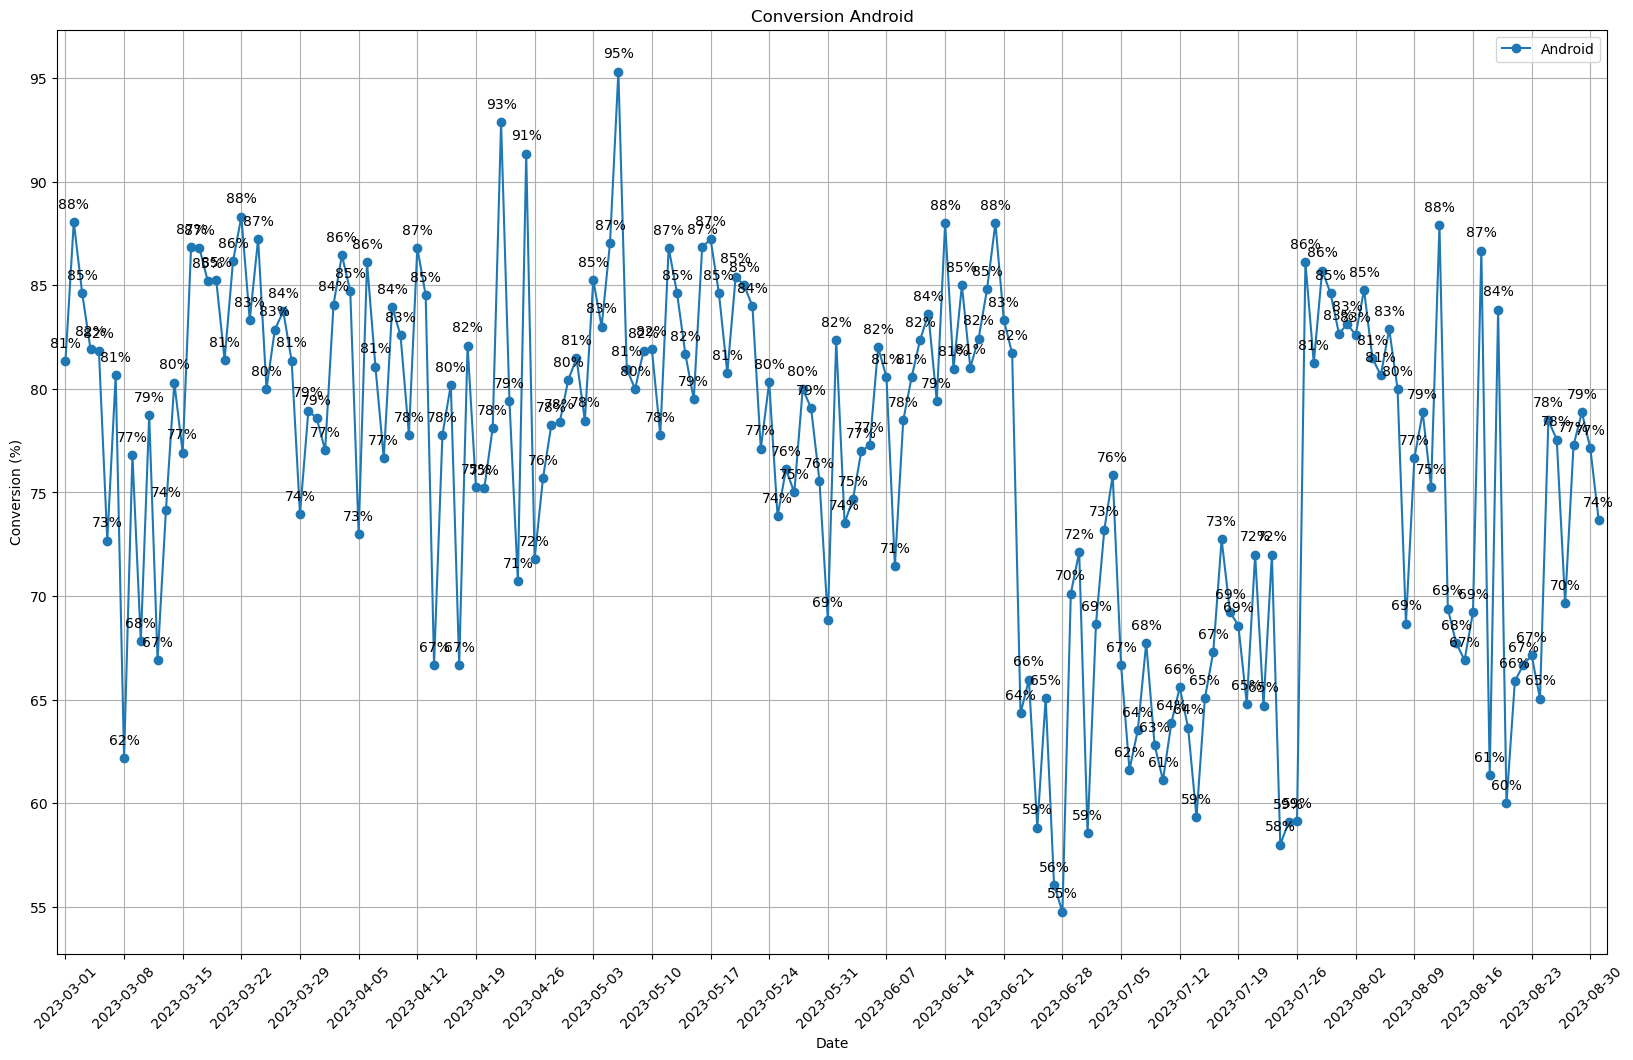

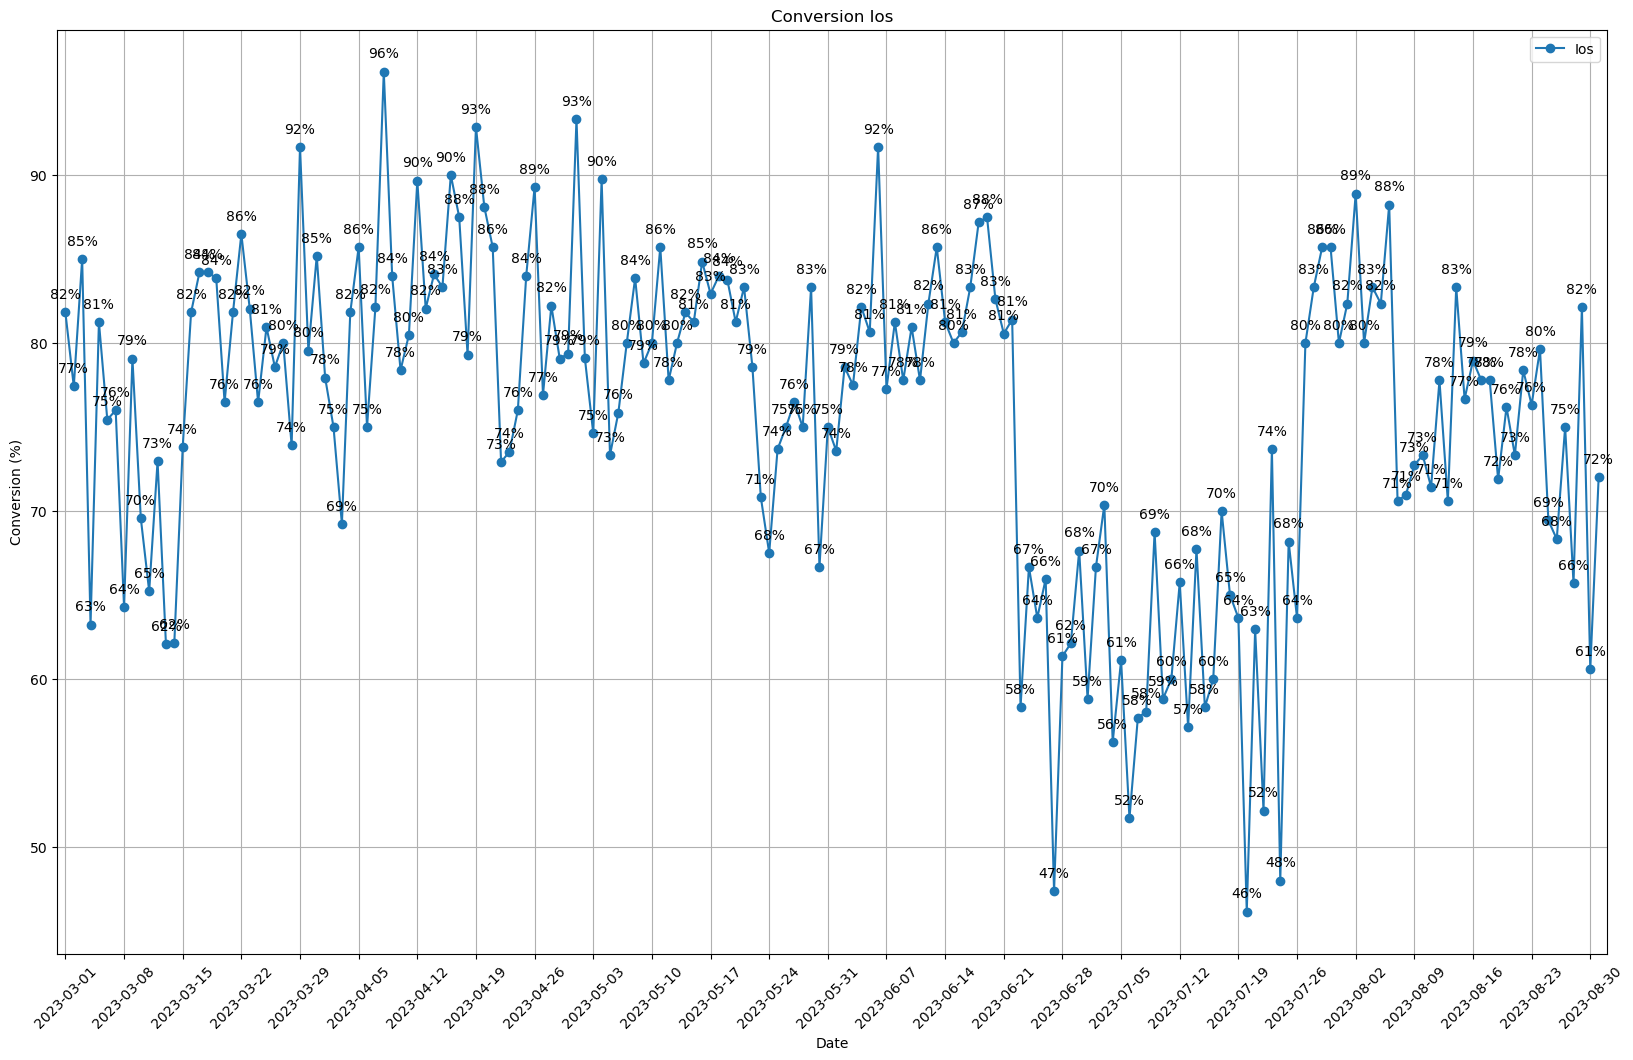

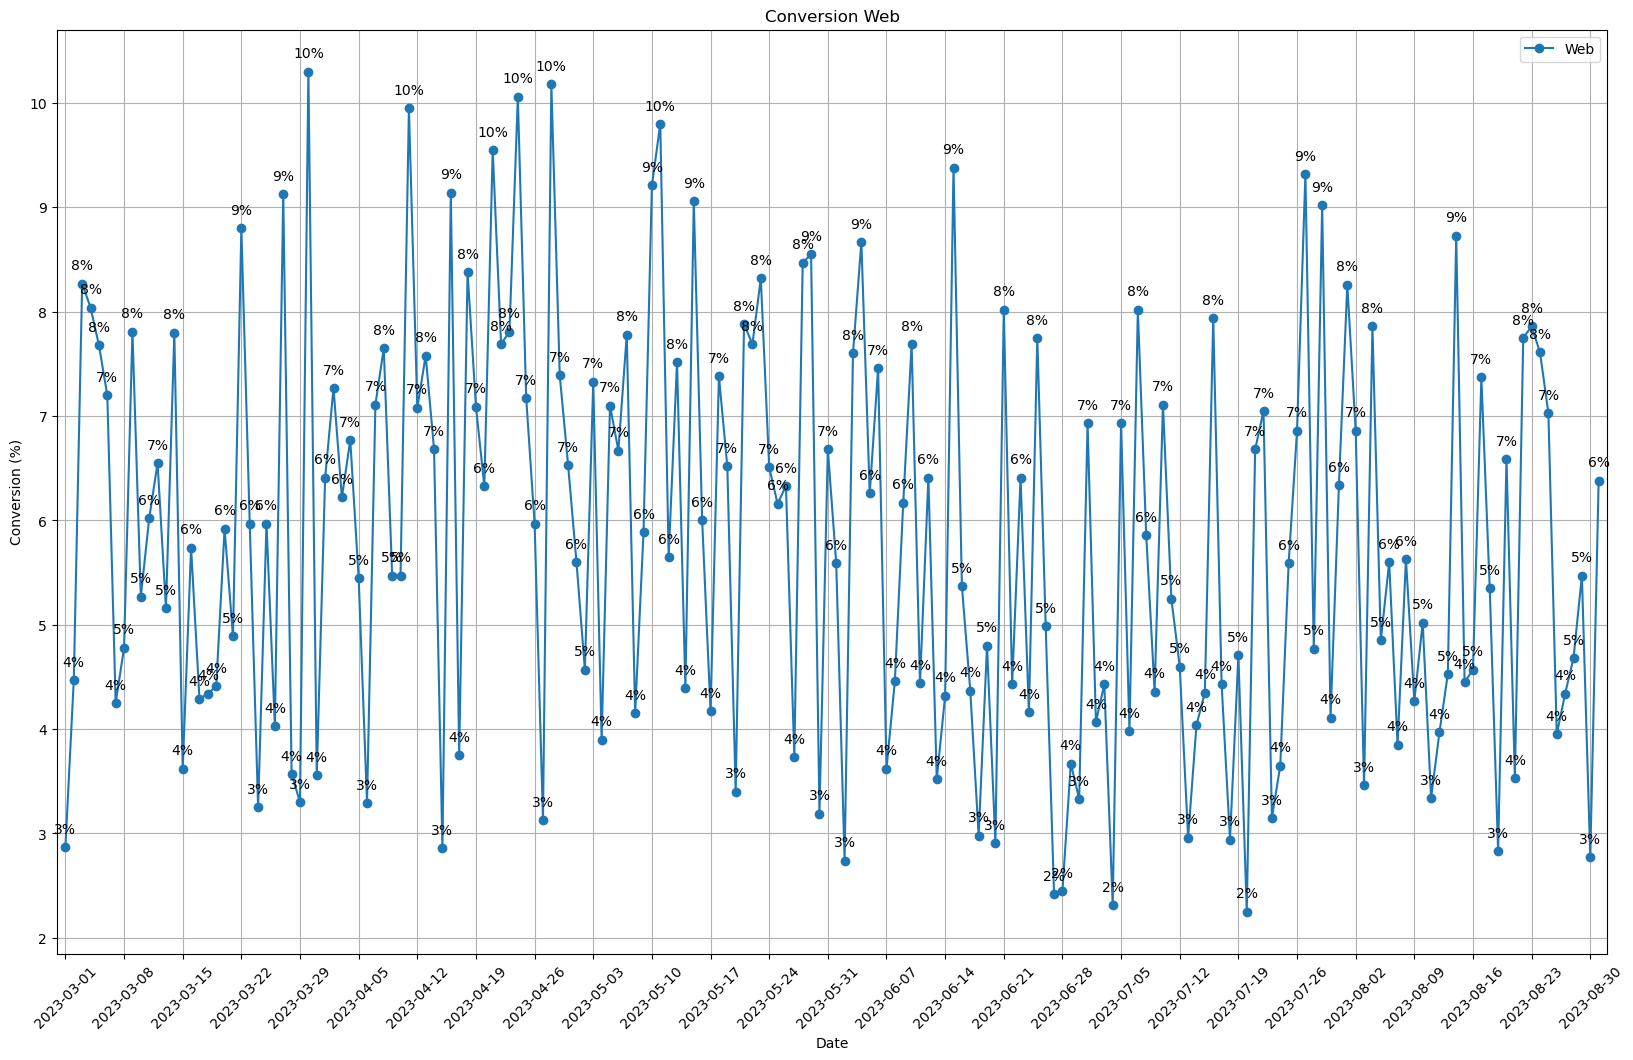

In [219]:
#Агрегируем данные для всех трех платформ
data_android = df_result[df_result['platform'] == 'android']
data_android.loc[:, 'conversion'] = data_android['conversion']

data_ios = df_result[df_result['platform'] == 'ios']
data_ios.loc[:, 'conversion'] = data_ios['conversion']

data_web = df_result[df_result['platform'] == 'web']
data_web.loc[:, 'conversion'] = data_web['conversion']

#Напишем функцию, которая принимает в качестве аргументов датафрейм и название платформы, она поможет нам отрисовать три одинаковых графика
def conversion_plot_builder(df, platform):
    #Создаем график
    plt.figure(figsize=(20, 12))
    plt.plot(df['date_group'], df['conversion'], marker='o', linestyle='-', label=platform)
    for i, txt in enumerate(df['conversion']):
        plt.annotate(f'{txt:.0f}%', (df['date_group'].iloc[i], df['conversion'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.title(f'Conversion {platform}')
    plt.xlabel('Date')
    plt.ylabel('Conversion (%)')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xlim(-1, len(df['date_group']))
    plt.grid() 
    plt.legend() 
    
    #Сохраняем график в формате PNG
    plt.savefig(f'./charts/conversion_{platform.lower()}.png')
    #Отрисовываем график
    plt.show()

#Вызываем нашу функцию
conversion_plot_builder(data_android, 'Android')
conversion_plot_builder(data_ios, 'Ios')
conversion_plot_builder(data_web, 'Web')

# График "Средняя конверсия"

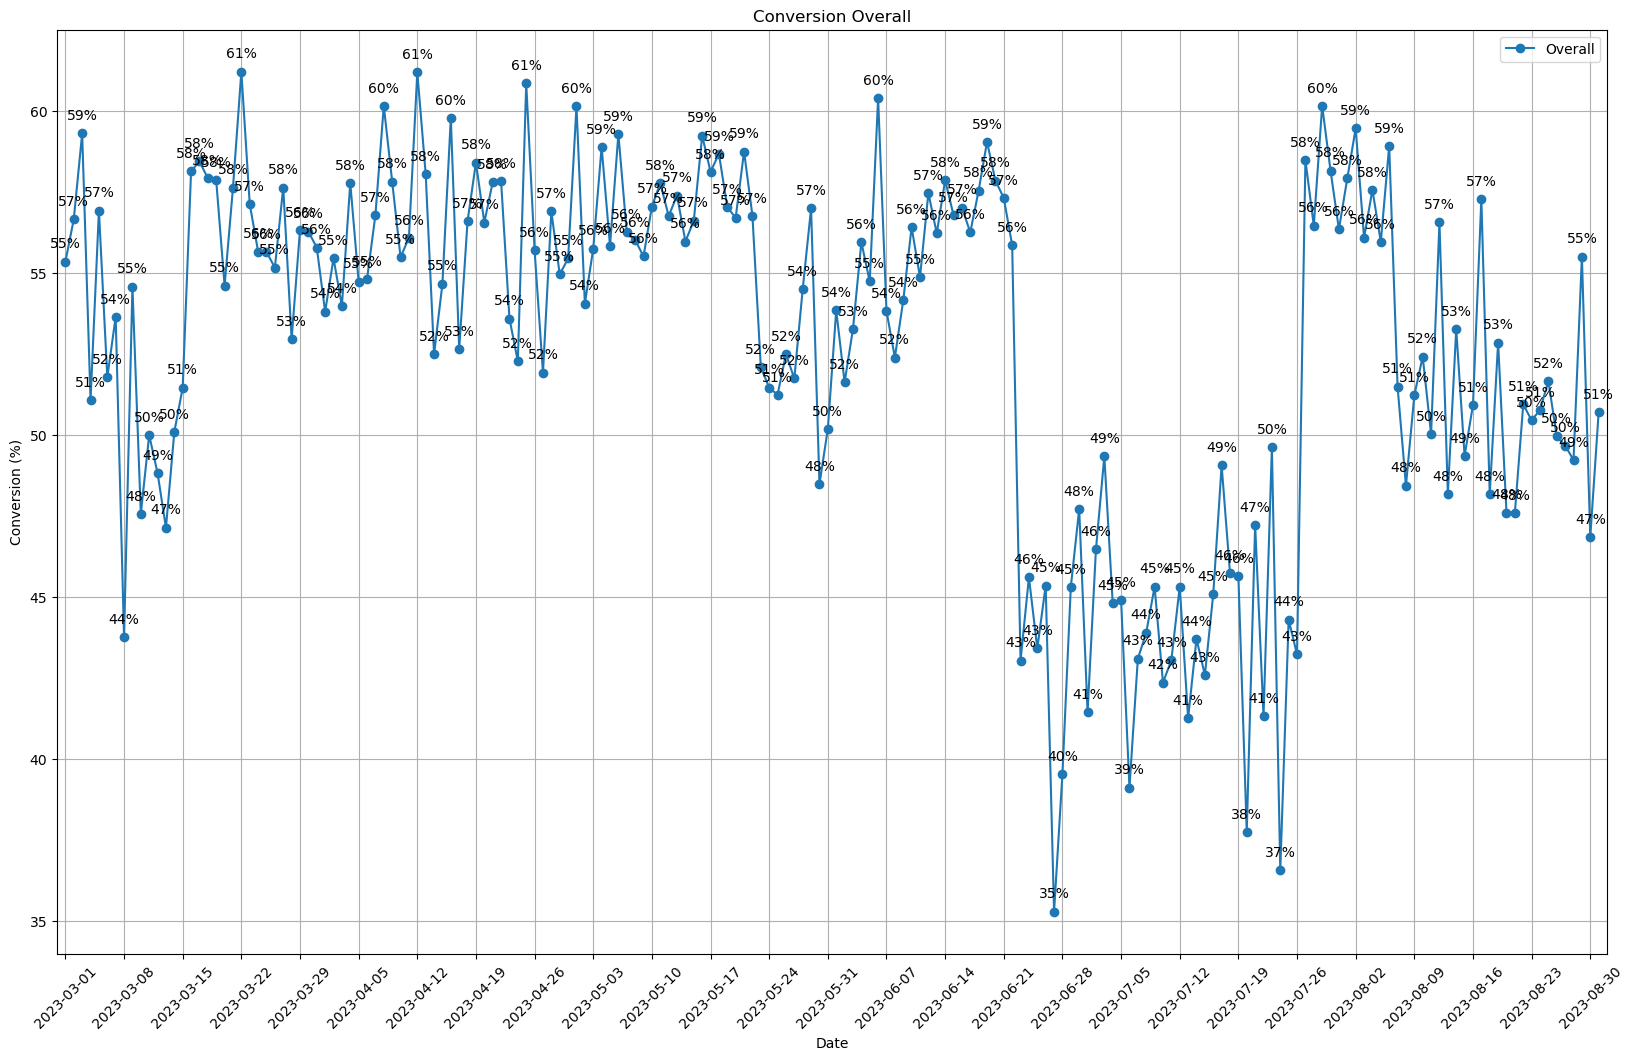

In [220]:
# Агрегируем данные
data = df_result.groupby('date_group')['conversion'].mean().reset_index()

#Создаем график с помощью conversion_plot_builder
conversion_plot_builder(data, 'Overall')

# График "Стоимости реклам"

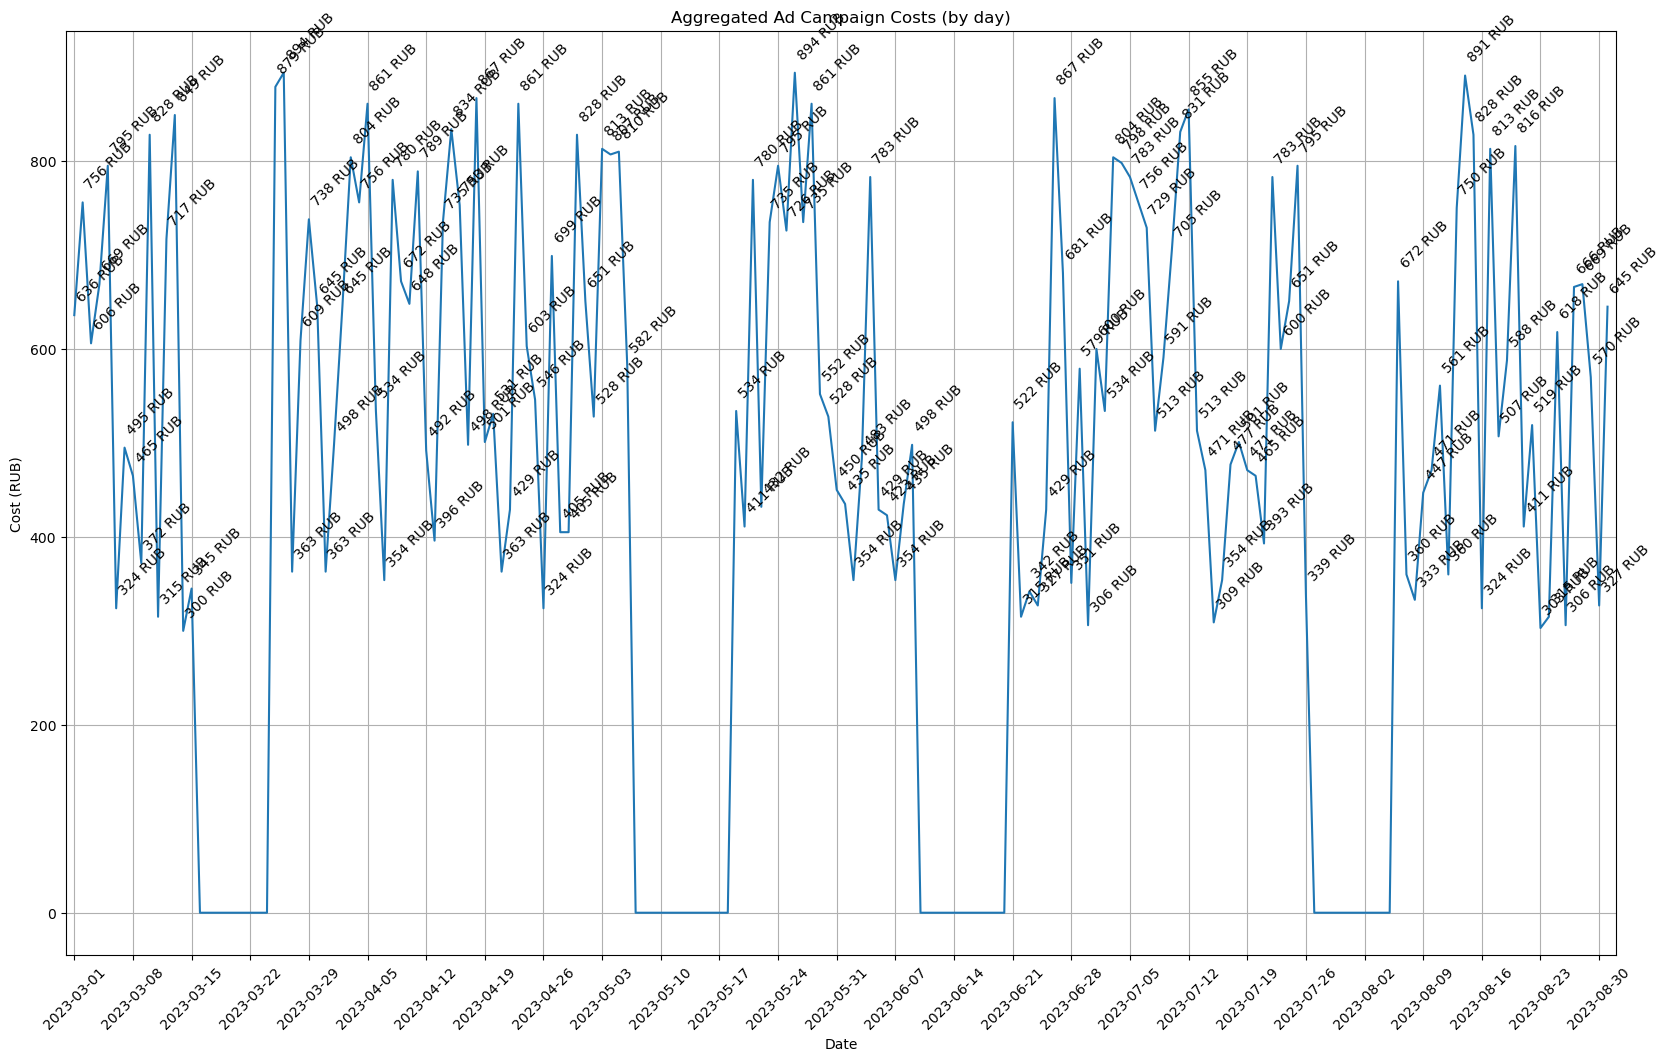

In [221]:
#Агрегируем данные
data = df_result.groupby('date_group')['cost'].sum().reset_index()
#Создаем график
plt.figure(figsize=(20, 12))
plt.plot(data['date_group'], data['cost'], linestyle='-')
for i, txt in enumerate(data['cost']):
    if int(txt) > 0:
        plt.annotate(f'{txt:.0f} RUB', (data['date_group'][i], data['cost'][i]), 
                     textcoords="offset points", xytext=(0,10), ha='left', rotation=45)
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xlim(-1, len(data['date_group']))
plt.grid() 
#Сохраняем график в формате PNG
plt.savefig('./charts/aggregated_ad_campaign_costs.png')

#Отрисовываем график
plt.show()

# График "Визиты за весь период с цветовым выделением рекламной кампании"

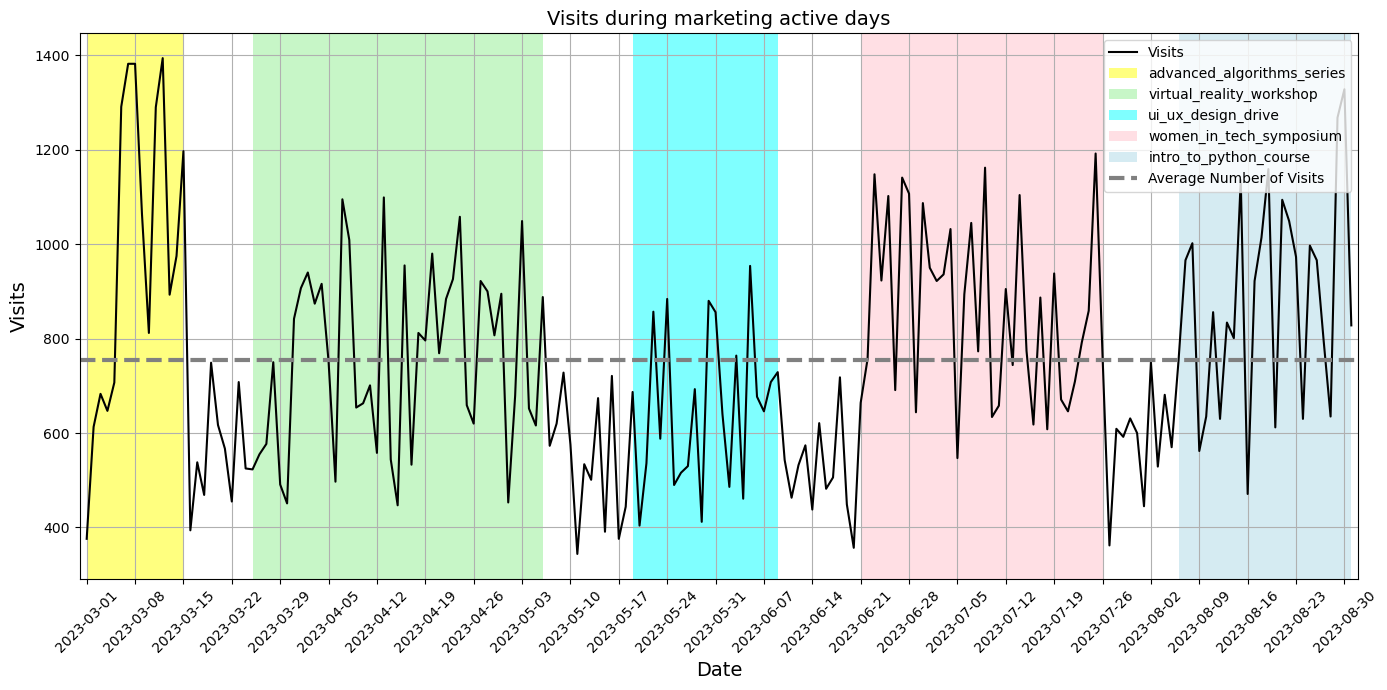

In [222]:
#Агрегируем данные
data = df_result.groupby(['date_group', 'utm_campaign'])['visits'].sum().reset_index()

#Создаем график       
plt.figure(figsize=(14, 7))       
plt.plot(data['date_group'], data['visits'], label='Visits', color='black')
utm_campaigns = data.utm_campaign.unique()
utm_campaigns = list(utm_campaigns)
utm_campaigns.remove('none')
utm_campaign_colors = ['yellow', 'lightgreen', 'cyan', 'pink', 'lightblue']
for i, utm_campaign in enumerate(utm_campaigns):
    data_campaign = data[data['utm_campaign'] == utm_campaign]
    plt.axvspan(data_campaign['date_group'].min(), data_campaign['date_group'].max(), facecolor=utm_campaign_colors[i], alpha=0.5, label=utm_campaign)
plt.axhline (y=np.nanmean(data['visits']), color='grey', linestyle='--', linewidth= 3 , label='Average Number of Visits')
plt.xticks(data['date_group'], rotation=45)
plt.legend(loc='upper right')
plt.title('Visits during marketing active days', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Visits', fontsize=14)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xlim(-1, len(data['date_group']))
plt.grid()
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/visits_during_marketing_active_days.png')

#Отрисовываем график
plt.show()

# График "Регистрации за весь период с цветовым выделением рекламной кампании"

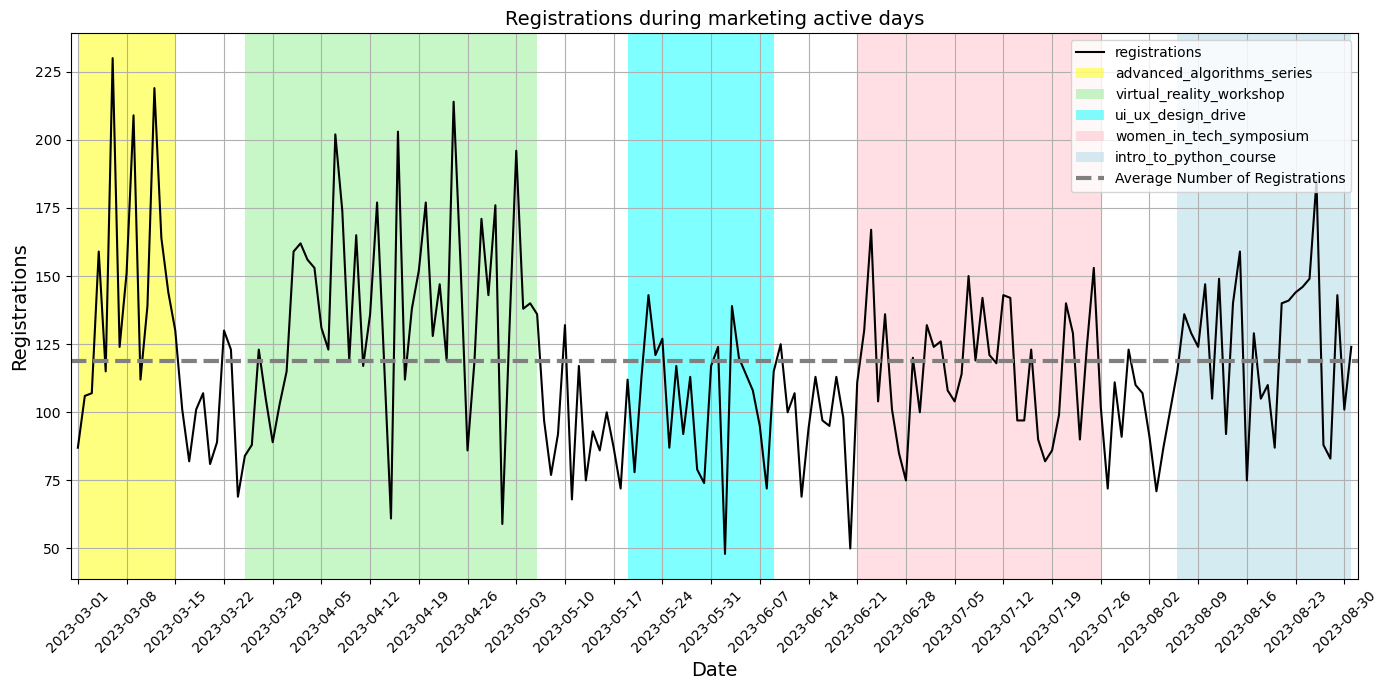

In [223]:
#Агрегируем данные
data = df_result.groupby(['date_group', 'utm_campaign'])['registrations'].sum().reset_index()

#Создаем график       
plt.figure(figsize=(14, 7))       
plt.plot(data['date_group'], data['registrations'], label='registrations', color='black')
utm_campaigns = data.utm_campaign.unique()
utm_campaigns = list(utm_campaigns)
utm_campaigns.remove('none')
utm_campaign_colors = ['yellow', 'lightgreen', 'cyan', 'pink', 'lightblue']
for i, utm_campaign in enumerate(utm_campaigns):
    data_campaign = data[data['utm_campaign'] == utm_campaign]
    plt.axvspan(data_campaign['date_group'].min(), data_campaign['date_group'].max(), facecolor=utm_campaign_colors[i], alpha=0.5, label=utm_campaign)
plt.axhline (y=np.nanmean(data['registrations']), color='grey', linestyle='--', linewidth= 3 , label='Average Number of Registrations')
plt.xticks(data['date_group'], rotation=45)
plt.legend(loc='upper right')
plt.title('Registrations during marketing active days', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Registrations', fontsize=14)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xlim(-1, len(data['date_group']))
plt.grid()
plt.tight_layout()

#Сохраняем график в формате PNG
plt.savefig('./charts/registrations_during_marketing_active_days.png')

#Отрисовываем график
plt.show()